# RF Modeling with Engineered Features

In [2]:
import pandas as pd
import numpy as np
from helper import * 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

# Import data and clean with wrapper

In [4]:
# importing data
housing = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0,low_memory = False)
# data processing
train, test = data_processing_wrapper(housing,
                                               num_to_cat_list = ['MSSubClass','MoSold'],
                                             remove_PID = False
                                        )

# feature engineering wrapper
train, test = feature_engineering_wrapper(train, test)

# importing school feature
schools = pd.read_csv('schoolFeatures.csv',index_col = 0)
school_keep = [
    'PID',
    'closestSchool'
]
schools = schools[school_keep]

# merge school feature onto original data set.
train = train.merge(schools, how = 'left', left_on = 'PID', right_on = 'PID')
test = test.merge(schools, how = 'left', left_on = 'PID', right_on = 'PID')

train = train.dropna(subset=['closestSchool'])
train = train.reset_index(drop=True)

test = test.dropna(subset=['closestSchool'])
test = test.reset_index(drop=True)

In [5]:
#housing started out with 81 columns (2580 rows)
#feature engineering - ended up with 129 columns (including PID and SalePrice)-- (added 48 new columns) (2477 rows between train and test)

# Split into predictors and target

In [6]:
train_raw = train.copy()
test_raw = test.copy()

train_X = train_raw.drop(['SalePrice','PID'],axis='columns')
train_y = train_raw['SalePrice']
test_X = test_raw.drop(['SalePrice','PID'],axis='columns')
test_y = test_raw['SalePrice']

In [7]:
train_y_log = np.log(train_y).rename('LogSalePrice')
test_y_log = np.log(test_y).rename('LogSalePrice')

In [8]:
cat_feats = train_X.select_dtypes(['object']).columns.to_list()
num_feats = train_X.select_dtypes(['int','float']).columns.to_list()

In [9]:
len(cat_feats) # 32 categorical features (43 originally in housing dataset)
len(num_feats) #95 numeric features (38 originally)

95

# Dummify 

In [10]:
#Preprocessing / Dummification
preprocessor = ColumnTransformer(transformers=[
    ('tf1',OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_feats)],remainder='passthrough')

train_X_transformed = preprocessor.fit_transform(train_X)

In [11]:
#Get one-hot encoded column names 
columns_transformed = preprocessor.named_transformers_['tf1'].get_feature_names(input_features= cat_feats)
new_columns = list(columns_transformed)+num_feats

#Place one-hot encoded train X into dataframe 
train_X_transformed = pd.DataFrame(train_X_transformed,columns=new_columns)

#Repeat for test X 
test_X_transformed = preprocessor.transform(test_X)
test_X_transformed = pd.DataFrame(test_X_transformed,columns=new_columns)

# Filter down Features Based off of LASSO 

In [12]:
#Features selected by LASSO model (non-zero coefficients)
coef_df = pd.read_csv('lasso_coef.csv',index_col=0) #Hayden shared this on Slack

In [13]:
selected_features = list(coef_df['features'])

In [14]:
print('Number of LASSO selected features: '+ str(len(selected_features)))

Number of LASSO selected features: 140


In [15]:
print('Number of total features after preprocessing: ' + str(len(train_X_transformed.columns.to_list())))

Number of total features after preprocessing: 323


In [16]:
#Filter dataframes down to the select_features 
train_X= train_X_transformed[selected_features]
test_X = test_X_transformed[selected_features]

# Random Forest Modeling 

In [17]:
#Function to print scores
def rf_summarize(model,Xtrain,ytrain,Xtest,ytest,num=10):

    print(model.get_params())
    print('\n')
    print('Cross Val score: ', cross_val_score(model, Xtrain, ytrain, cv=5))
    print('Cross Val score mean: ', cross_val_score(model, Xtrain, ytrain, cv=5).mean())
    print('Train score: ',model.score(Xtrain,ytrain))
    print('Test score: ',model.score(Xtest,ytest))
    print('\n')
    importances = pd.Series(model.feature_importances_, index = Xtrain.columns).sort_values(ascending=False)
    print(importances[:num])

## 1. Without Tuning

### 1A. Feature Selection

In [18]:
rf = RandomForestRegressor(random_state=0)
rf.fit(train_X, train_y_log)
rf_summarize(rf,train_X,train_y_log,test_X,test_y_log)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


Cross Val score:  [0.92436102 0.93526875 0.92429566 0.92783612 0.91877842]
Cross Val score mean:  0.9261079946056376
Train score:  0.98945671606562
Test score:  0.8984127748003494


OverallQual_cubed               0.428616
total_sf_square_root            0.289976
total_high_qual_finished_sf     0.091691
Neighborhood_log_comp           0.043746
overall_score_square_root       0.035583
GarageArea                      0.012643
year_since_built_square_root    0.011987
GrLivArea_square_root           0.009343
YearRemodAdd                    0.006577
LotArea_squared                 0.005978
dtype: floa

In [19]:
#Try with SalePrice instead of log
rf = RandomForestRegressor(random_state=0)
rf.fit(train_X, train_y)
rf_summarize(rf,train_X,train_y,test_X,test_y)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


Cross Val score:  [0.94446388 0.91958566 0.91982172 0.93378899 0.91650559]
Cross Val score mean:  0.9268331674017437
Train score:  0.9892740184526548
Test score:  0.8661877287542651


OverallQual_cubed               0.399807
total_sf_square_root            0.350979
total_high_qual_finished_sf     0.077981
Neighborhood_log_comp           0.055797
overall_score_square_root       0.017134
year_since_built_square_root    0.009403
GrLivArea_square_root           0.008955
GarageArea                      0.008135
YearRemodAdd                    0.007042
LotArea_square_root             0.005311
dtype: fl

### 1B. All Features

In [20]:
#No feature selection

In [21]:
rf = RandomForestRegressor(random_state=0)
rf.fit(train_X_transformed, train_y_log)
rf_summarize(rf,train_X_transformed,train_y_log,test_X_transformed,test_y_log)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


Cross Val score:  [0.92248157 0.93275171 0.92364538 0.9245361  0.91484611]
Cross Val score mean:  0.9236521747474592
Train score:  0.9891372042859093
Test score:  0.8952997288692605


OverallQual                    0.118576
OverallQual_square_root        0.104625
OverallQual_cubed              0.103060
OverallQual_squared            0.101697
total_high_qual_finished_sf    0.088775
total_sf                       0.081656
total_sf_square_root           0.073389
total_sf_cubed                 0.071333
total_sf_squared               0.060984
Neighborhood_log_comp          0.042242
dtype: float64


In [22]:
#remove log on target 
rf = RandomForestRegressor(random_state=0)
rf.fit(train_X_transformed, train_y)
rf_summarize(rf,train_X_transformed,train_y,test_X_transformed,test_y)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


Cross Val score:  [0.94421031 0.91529305 0.91735592 0.92721745 0.91035143]
Cross Val score mean:  0.9228856324406379
Train score:  0.9888767085758192
Test score:  0.8638453763909857


OverallQual_squared            0.123926
total_sf_cubed                 0.105298
OverallQual                    0.104546
total_sf_square_root           0.104352
OverallQual_cubed              0.087981
OverallQual_square_root        0.082700
total_high_qual_finished_sf    0.074941
total_sf_squared               0.070564
total_sf                       0.068816
Neighborhood_log_comp          0.053998
dtype: float64


## 2. With Tuning

### 2A. Feature Selection

In [23]:
random_forest_1 = RandomForestRegressor(n_estimators=475, 
                                      max_depth=23, 
                                      max_features=0.28, 
                                      n_jobs=-1,
                                      random_state=0,
                                      )

In [24]:
random_forest_1.fit(train_X,train_y_log)

RandomForestRegressor(max_depth=23, max_features=0.28, n_estimators=475,
                      n_jobs=-1, random_state=0)

In [25]:
rf_summarize(random_forest_1,train_X, train_y_log, test_X, test_y_log,140)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 23, 'max_features': 0.28, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 475, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


Cross Val score:  [0.93289584 0.93699087 0.92947119 0.92741967 0.92810134]
Cross Val score mean:  0.9309757800768785
Train score:  0.9909824689781673
Test score:  0.9109286902705149


total_sf_square_root                2.195548e-01
OverallQual_cubed                   1.912288e-01
total_high_qual_finished_sf         1.157459e-01
Neighborhood_log_comp               9.126466e-02
GrLivArea_square_root               5.409430e-02
year_since_built_square_root        4.514434e-02
ExterQual                           3.805758e-02
overall_score_square_root           3.425391e-02
GarageArea                       

In [150]:
colors = ["#FF0B04", "#F1BE48",
           "#B9975B", "#8B5B29",
           "#524727",
         ]

colors = ["#B9975B"]

In [151]:
importances = pd.DataFrame(pd.Series(random_forest_1.feature_importances_, index = train_X.columns). \
                           sort_values(ascending=False)).reset_index()

In [152]:
importances.columns = ['Feature','Importance']


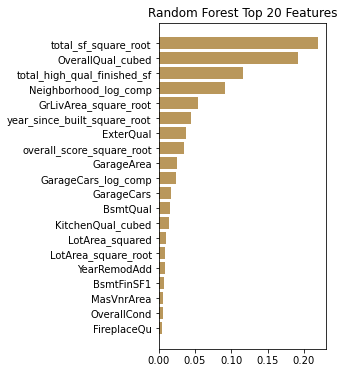

In [153]:
top = importances[:20].sort_values(by='Importance',ascending=True)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [3.0, 6.0]
plt.barh(top['Feature'], top['Importance'],color=colors)
plt.title('Random Forest Top 20 Features')
plt.savefig('RF_Top_1.png',dpi=300, bbox_inches='tight')

In [26]:
#Results for tuned rf with feature selection
# {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 23, 'max_features': 0.28, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 475, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


# Cross Val score:  [0.93289584 0.93699087 0.92947119 0.92741967 0.92810134]
# Cross Val score mean:  0.9309757800768785
# Train score:  0.9909824689781674
# Test score:  0.9109286902705149


# total_sf_square_root            0.219555
# OverallQual_cubed               0.191229
# total_high_qual_finished_sf     0.115746
# Neighborhood_log_comp           0.091265
# GrLivArea_square_root           0.054094
# year_since_built_square_root    0.045144
# ExterQual                       0.038058
# overall_score_square_root       0.034254
# GarageArea                      0.025890
# GarageCars_log_comp             0.023409
# GarageCars                      0.016580
# BsmtQual                        0.015127
# KitchenQual_cubed               0.014063
# LotArea_squared                 0.009416
# LotArea_square_root             0.009276
# YearRemodAdd                    0.008412
# BsmtFinSF1                      0.007112
# MasVnrArea                      0.005505
# OverallCond                     0.005320
# FireplaceQu                     0.005196
# total_deck_sf                   0.004939
# garage_score                    0.004545
# Fireplaces                      0.004404
# TotRmsAbvGrd                    0.003296
# total_full_bath                 0.003209

### 2B. All Features

In [169]:
random_forest_2 = RandomForestRegressor(n_estimators=300, 
                                      max_depth=36, 
                                      max_features=0.1, 
                                      n_jobs=-1,
                                      random_state=0,
                                      )

In [170]:
random_forest_2.fit(train_X_transformed,train_y_log)
rf_summarize(random_forest_2,train_X_transformed,train_y_log,test_X_transformed,test_y_log,25)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 36, 'max_features': 0.1, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


Cross Val score:  [0.93273479 0.93491204 0.92292383 0.92370534 0.92157475]
Cross Val score mean:  0.9271701501791497
Train score:  0.990276972313275
Test score:  0.9042749333234227


total_sf_squared               0.069766
total_sf_cubed                 0.065509
total_sf                       0.065176
OverallQual                    0.064999
OverallQual_squared            0.062314
total_sf_square_root           0.056356
OverallQual_cubed              0.052879
OverallQual_square_root        0.052504
total_high_qual_finished_sf    0.041294
Neighborhood_log_comp          0.035703
GrLivArea_squared          

In [171]:
# #Results tuned RF with all features 
# {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 36, 'max_features': 0.1, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


# Cross Val score:  [0.93273479 0.93491204 0.92292383 0.92370534 0.92157475]
# Cross Val score mean:  0.9271701501791497
# Train score:  0.990276972313275
# Test score:  0.9042749333234227


# total_sf_squared               0.069766
# total_sf_cubed                 0.065509
# total_sf                       0.065176
# OverallQual                    0.064999
# OverallQual_squared            0.062314
# total_sf_square_root           0.056356
# OverallQual_cubed              0.052879
# OverallQual_square_root        0.052504
# total_high_qual_finished_sf    0.041294
# Neighborhood_log_comp          0.035703
# GrLivArea_squared              0.021725
# GrLivArea_square_root          0.018254
# YearBuilt                      0.018155
# GrLivArea                      0.016954
# ExterQual                      0.016779
# GrLivArea_cubed                0.016003
# year_since_built               0.013609
# GarageArea                     0.012863
# overall_score_square_root      0.012749
# year_since_built_cubed         0.012197
# GarageArea_cubed               0.011254
# overall_score_squared          0.011082
# overall_score_cubed            0.010948
# GarageCars_log_comp            0.010864
# GarageArea_squared             0.009674
# dtype: float64

In [172]:
importances = pd.DataFrame(pd.Series(random_forest_2.feature_importances_, index = train_X_transformed.columns). \
                           sort_values(ascending=False)).reset_index()

In [173]:
importances.columns = ['Feature','Importance']

In [174]:
colors = ["#FF0B04", "#F1BE48",
           "#B9975B", "#8B5B29",
           "#524727",
         ]

colors = ["#B9975B"]

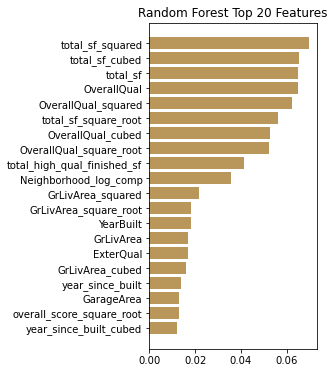

In [175]:
top = importances[:20].sort_values(by='Importance',ascending=True)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [3.0, 6.0]
plt.barh(top['Feature'], top['Importance'],color=colors)
plt.title('Random Forest Top 20 Features')
plt.savefig('RF_Top_2.png',dpi=300, bbox_inches='tight')

In [163]:
topLasso = coef_df.sort_values(by='coefs',ascending=False)[:20] #grab top 20 features sorted by coef positive to negative
topLasso = topLasso.sort_values(by='coefs',ascending=True) #reverse order of selection so that it plots in a descending order 

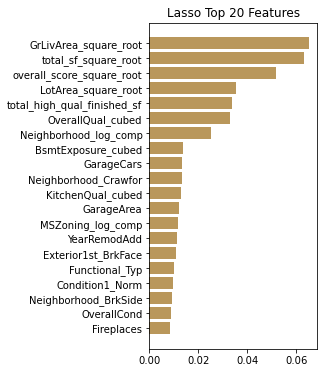

In [164]:
#lasso graph
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [3.0, 6.0]
plt.barh(topLasso['features'], topLasso['coefs'],color=colors)
plt.title('Lasso Top 20 Features')
plt.savefig('Lasso_Top_1.png',dpi=300, bbox_inches='tight')